In [107]:
import random as rand
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
from tqdm import tqdm

#Fix the randomness
seed = 1234
rand.seed(seed)

import pandas as pd
import random

def load_data(input_file):
    data = pd.read_csv(input_file)
    return data

def split_data(input_file, output_file_1, output_file_2, ratio_split=0.2):
    df = pd.read_csv(input_file)

    # Remove columns: date, country, street (Since every data is collected inside USA)
    df = df.drop(columns=["date", "country", "street"])

    # 1. Filter noisy data (house with prices == 0.0)
    df = df[df["price"] > 100]

    # 2. Remove all the records containing null_values 
    df = df.dropna()

    # 3. Remove the records belong to the cities that has less than 5 instances
    city_counts = df['city'].value_counts()
    
    cities_to_keep = city_counts[city_counts >= 5].index
    df = df[df['city'].isin(cities_to_keep)]

    ## Normalize the data:
    #1. year_built = subtract the minimum year_built from all the year_built
    #2. year_renovated = make 3 classes, 0 is never renovated, 1 is renovated before 2000, 2 is renovated after 2000 
    #3. sqft_living = normalize
    #4. sqft_lot = normalize
    #5. sqft_above = normalize
    #6. sqft_basement = normalize

    # 1. Normalize the yr_built
    print(f"Minimum yr_built: {df['yr_built'].min()}")
    df['yr_built'] = df['yr_built'] - df['yr_built'].min()
    
    # 2. Normalize the year_renovated
            # 0: Not rennovated
            # 1: From 1900 to 1920
            # 2: From 1920 to 1940
            # 3: From 1940 to 1960
            # 4: From 1960 to 1980
            # 5: From 1980 to 2000
            # 6: From 2000 to now
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    df['yr_renovated'].hist(bins=32, edgecolor='black', ax=axes[0])
    axes[0].set_xlabel('Values in yr_renovated')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Histogram of Values in yr_renovated')

    df[df['yr_renovated'] != 0]['yr_renovated'].hist(bins=32, edgecolor='black', ax=axes[1])
    axes[1].set_xlabel('Values in yr_renovated')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Histogram of Non-Zero Values in yr_renovated')
    plt.tight_layout()
    plt.show()

    bins = [-1, 1899, 1920, 1940, 1960, 1980, 2000, pd.to_datetime('now').year]
    labels = [0, 1, 2, 3, 4, 5, 6]
    df['yr_renovated'] = pd.cut(df['yr_renovated'], bins=bins, labels=labels, right=False)

    # 3. Normalize all the square feet

    columns_to_normalize = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
    scaler = MinMaxScaler()
    df[columns_to_normalize] = scaler.fit_transform(df[columns_to_normalize])

    # PLOTTING: 
    columns_of_interest = ['sqft_living', 'sqft_above', 'sqft_basement', 'sqft_lot']
    subset_df = df[columns_of_interest]
    correlation_matrix = subset_df.corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
    plt.title('Correlation Matrix Heatmap (sqft features)')
    plt.show()




    df = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    total_rows = len(df)
    split_index = int(total_rows * (1 - ratio_split))

    set_1 = df.iloc[:split_index, :]
    set_2 = df.iloc[split_index:, :]

    set_1.to_csv(output_file_1, index=False, header = True)
    set_2.to_csv(output_file_2, index=False, header = True)
    return None

## 0. Informations on the dataset:

- date: The date when the house sale occurred. 
- price: The price at which the house was sold.
- bedrooms: The number of bedrooms in the house.
- bathrooms: The number of bathrooms in the house.
- sqft_living: The total living area in square feet. 
- sqft_lot: The total lot area in square feet. It represents the total land area of the property.
- floors: The number of floors or levels in the house.
- waterfront: A binary indicator (0 or 1) that specifies whether the house has a waterfront view or not.
- view: An index from 0 to 4 representing the quality of the view from the property.
- condition: An index from 1 to 5 representing the overall condition of the house. (the greater the better)
- sqft_above: The square footage of the interior living space that is above ground level.
- sqft_basement: The square footage of the interior living space that is below ground level.
- yr_built: The year the house was originally built.
- yr_renovated: The year of the last renovation. If the house has never been renovated, this is 0.
- street: The street address of the house.
- city: The city where the property is located.
- statezip: The state and ZIP code of the property.
- country: The country where the property is located. It's important to note that this dataset may predominantly contain properties from a specific country, so the 'country' feature might not provide much variation.

## 1. Create the database.txt file and evalutation.txt

In [108]:
# input_file_path = 'data.csv'
# output_file_1_path = 'database.csv'
# output_file_2_path = 'evaluation.csv'
# split_ratio = 0.2

# split_data(input_file_path, output_file_1_path, output_file_2_path, split_ratio)

## 2. Load the dataset 

In [109]:
database = load_data('database.csv')
# #Normalize the data:
# database=(database-database.min())/(database.max()-database.min())

evaluation = load_data('evaluation.csv')

#Create a dictionary for weights:
weight_dist = {}
#between 0 and 1
weight_dist['sqft_living'] = 1.0
weight_dist['sqft_above'] = 0.5 
weight_dist['sqft_basement'] = 0.5
weight_dist['sqft_lot'] = 0.5
weight_dist['waterfront'] = 0.2

#between 0 and 6
weight_dist['yr_renovated'] = 0.005

#between 0 and 4
weight_dist['view'] = 0.05

#between 0 and 3
weight_dist['condition'] = 0.05

#between 0 and around 120
weight_dist['yr_built'] = 0.0005

#else
weight_dist['bedrooms'] = 0.01
weight_dist['bathrooms'] = 0.01
weight_dist['floors'] = 0.01

#Pick a random sample from database
sample = database.iloc[2828]


#Weight dict for the adaptation:
weight_dict = {'waterfront': 0.25, 'view': 0.01, 'yr_renovated': 0.005, 'yr_built': 0.0005, 'condition': 0.01, 'bedrooms': 0.01,\
                'bathrooms': 0.01, 'floors': 0.01, 'sqft_living': 1.0, 'sqft_above': 0.5, 'sqft_basement': 0.5, 'sqft_lot': 0.15}

In [110]:
print(database.head(4))
print("---------------------------------")
print(f"A sample : {sample}")
print("---------------------------------")
print(f"The weight dictionary for distance calculation: {weight_dist}")

       price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0   479900.0       3.0        2.0     0.122248  0.010723     1.0           0   
1  1120000.0       5.0        1.5     0.164768  0.005609     2.0           0   
2   625000.0       4.0        1.0     0.093394  0.004529     1.5           0   
3   400000.0       2.0        1.0     0.035687  0.004538     1.0           0   

   view  condition  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3    0.178097       0.000000        94             0   
1     3          4    0.217920       0.041494        54             4   
2     0          4    0.136062       0.000000        46             5   
3     0          3    0.051991       0.000000        55             6   

      city  statezip  
0     Kent  WA 98042  
1  Seattle  WA 98136  
2  Seattle  WA 98117  
3  Seattle  WA 98136  
---------------------------------
A sample : price            477000.0
bedrooms              3.0
bathrooms            

In [111]:
communities = database.groupby(['city', 'statezip']).size().reset_index(name='numberOfInstances')
print(communities) #102 communities

           city  statezip  numberOfInstances
0        Algona  WA 98001                  5
1        Auburn  WA 98001                 41
2        Auburn  WA 98002                 31
3        Auburn  WA 98092                 68
4      Bellevue  WA 98004                 42
..          ...       ...                ...
91      Tukwila  WA 98178                  3
92      Tukwila  WA 98188                  5
93       Vashon  WA 98070                 23
94  Woodinville  WA 98072                 46
95  Woodinville  WA 98077                 45

[96 rows x 3 columns]


In [112]:
communities_dict = {}
for city, city_group in database.groupby('city'):
    city_dict = {}
    for (zipcode, zip_group) in city_group.groupby('statezip'):
        city_dict[zipcode] = zip_group.drop(columns=['city', 'statezip'])
    communities_dict[city] = city_dict

# Testing
print(communities_dict["Algona"]["WA 98001"])

         price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
252   196440.0       3.0        2.0     0.090357  0.006254     1.0   
468   100000.0       2.0        1.0     0.041002  0.019898     1.0   
1051  262000.0       4.0        2.5     0.125285  0.005214     2.0   
2242  230000.0       3.0        1.0     0.077449  0.014309     1.0   
2356  248000.0       4.0        3.0     0.136143  0.004886     2.0   

      waterfront  view  condition  sqft_above  sqft_basement  yr_built  \
252            0     0          3    0.131637            0.0        92   
468            0     0          3    0.059735            0.0        56   
1051           0     0          3    0.182522            0.0       102   
2242           0     0          4    0.112832            0.0        60   
2356           0     0          3    0.198341            0.0       106   

      yr_renovated  
252              0  
468              6  
1051             0  
2242             6  
2356             0  


## 3. Functions to find communities, neighbors and adaptat price for prediction 

In [113]:
def find_community(sample, communities_dict, neighborhood_mini=5):
    #Return a dataframe
    sample_zipcode = sample['statezip']
    sample_city = sample['city']
    closest_zone_samples = communities_dict[sample_city][sample_zipcode]
    if(len(closest_zone_samples) > neighborhood_mini):
        return closest_zone_samples
    else:
        closest_zone_samples = pd.DataFrame()
        for statezip in communities_dict[sample_city]:
            closest_zone_samples = pd.concat([closest_zone_samples, communities_dict[sample_city][statezip]])
        return closest_zone_samples

def find_k_neighbors(sample, communities_dict, k=5):
    closest_zone_samples = find_community(sample, communities_dict, neighborhood_mini=k)
    samples_distance = []
    all_diffs = []

    for idx, neighbor in closest_zone_samples.iterrows():
        distance, diffs = cal_distance(sample, neighbor)
        samples_distance.append((idx, distance))
        all_diffs.append(diffs)

    samples_distance.sort(key=lambda x: x[1])  # Sort by distance
    k_neighbors_indices = [idx for idx, _ in samples_distance[:k]]
    k_neighbors_dataframe = closest_zone_samples.loc[k_neighbors_indices]
    return k_neighbors_dataframe, all_diffs

def cal_distance(sample, another_sample, weight_dist = weight_dist):
    difference = 0.0
    each_var_diff = {}
    for k,v in weight_dist.items():
        difference += v * abs(sample[k] - another_sample[k])
        each_var_diff[k] = v * abs(sample[k] - another_sample[k])
    return difference, each_var_diff

def adapt_price_from_dissimilarities(sample, neighbors, weight_dict, scale = 1000):
    list_predicted_price = []
    for index, neighbor in neighbors.iterrows():
        init_price = neighbor['price']
        estimated_difference = []
        for key in ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']:
            if neighbor[key] != 0:
                square_meter_price = init_price / neighbor[key]
                diff = weight_dict[key] * square_meter_price * (sample[key] - neighbor[key])
                estimated_difference.append(diff)
        
        init_price += np.mean(estimated_difference)
        for key in weight_dict.keys():
            init_price += scale * (sample[key] - neighbor[key])
        list_predicted_price.append(init_price)
    return np.mean(list_predicted_price)

In [114]:
find_community(sample, communities_dict, neighborhood_mini=3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated
316,425000.0,3.0,2.50,0.113895,0.004481,2.0,0,0,3,0.165929,0.000000,103,0
346,400000.0,4.0,2.50,0.164009,0.006450,1.0,0,0,3,0.118363,0.226141,78,0
515,443000.0,3.0,2.25,0.117692,0.007065,2.0,0,0,4,0.171460,0.000000,89,0
765,571000.0,3.0,2.50,0.169324,0.006359,2.0,0,0,3,0.246681,0.000000,88,6
1101,458000.0,5.0,2.50,0.206530,0.021076,1.0,0,0,3,0.289823,0.020747,57,6
1153,540000.0,5.0,3.00,0.189825,0.003475,2.0,0,0,3,0.190265,0.161826,107,0
1166,531000.0,3.0,2.50,0.132878,0.008474,2.0,0,0,3,0.193584,0.000000,88,6
1311,435000.0,4.0,2.75,0.132118,0.007557,1.0,0,0,3,0.126106,0.124481,62,6
1402,425000.0,3.0,2.25,0.113895,0.007789,1.0,0,0,3,0.118363,0.089212,78,0
1481,420000.0,3.0,1.75,0.097950,0.008348,1.0,0,0,3,0.111726,0.058091,81,6


## 4. Optimize and test the prediction process

### 4.0 Looking the scale of diffs values used to get distance, to optimise weights

In [115]:

# #run on all examples, saving diffs for each variables in each example in arr_of_diffs
# arr_of_diffs = []
# for index, sample in tqdm(evaluation.iterrows()):
#     nearest_neighbor, diffs = find_k_neighbors(sample,communities_dict, k = 3)
#     arr_of_diffs.append(diffs)

# #get max values of each feature in diffs
# max_diffs = {}
# for key in weight_dict.keys():
#     max_diffs[key] = 0
# for diffs in arr_of_diffs:
#     for diff in diffs:
#         for key in weight_dict.keys():
#             if diff[key] > max_diffs[key]:
#                 max_diffs[key] = diff[key]

# sorted_max_diffs = sorted(max_diffs.items(), key=lambda x: x[1], reverse=True)
# for key, value in sorted_max_diffs:
#     print(f"{key}: {value}")

# #from this point we just optimized the weights manually in weight_dist


### 4.1 Searching for the best scale value, with adaptation and 3 neighbors

In [116]:
# list_scales = [x for x in range (550,601)]
# list_losses = []

# count = 0
# for scale in tqdm(list_scales):
#     scale_loss = []
#     for index, row in evaluation.iterrows():
#         sample = row
#         nearest_neighbor, _ = find_k_neighbors(sample,communities_dict, k = 3)
#         predicted_price = adapt_price_from_dissimilarities(sample, nearest_neighbor, weight_dict, scale = scale)
#         actual_price = sample["price"]

#         scale_loss.append(abs(actual_price - predicted_price))
#     list_losses.append(np.mean(scale_loss))


# plt.plot(list_scales, list_losses, label='Mean Absolute Difference')
# plt.xlabel('Scale')
# plt.ylabel('Mean Absolute Difference')
# plt.title('Scale and Mean Absolute Difference')
# min_value = np.min(list_losses)
# min_scale = list_scales[np.argmin(list_losses)]
# plt.scatter(min_scale, min_value, color='red', label=f'Min Value ({min_scale}, {min_value:.2f})')
# plt.legend()
# plt.show()


In [117]:
#to avoid running scale value research again, we set it to the best found out value
try: 
    min_scale
except NameError: 
    min_scale = 573

### 4.2 Without adaptation, with the best scale value, with 3 neighbors

908it [00:20, 43.95it/s]


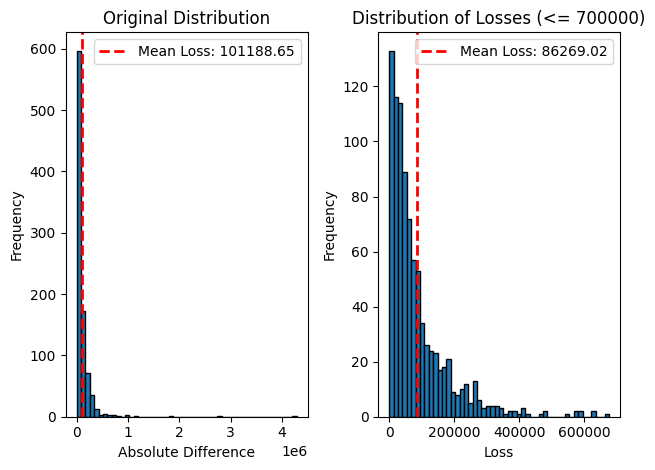

In [118]:
scale = min_scale
loss = []
for index, sample in tqdm(evaluation.iterrows()):
    nearest_neighbor, _ = find_k_neighbors(sample,communities_dict, k = 3)
    actual_price = sample["price"]
    predicted_price = np.mean(nearest_neighbor["price"])
    loss.append(abs(actual_price - predicted_price))

mean_loss = np.mean(loss)
plt.subplot(1, 2, 1)
plt.hist(loss, bins=50, edgecolor='black')
plt.axvline(mean_loss, color='red', linestyle='dashed', linewidth=2, label=f'Mean Loss: {mean_loss:.2f}')
plt.title('Original Distribution')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.legend()

filtered_losses = [l for l in loss if l <= 700000]
mean_loss = np.mean(filtered_losses)
plt.subplot(1, 2, 2)
plt.hist(filtered_losses, bins=50, edgecolor='black')
plt.axvline(mean_loss, color='red', linestyle='dashed', linewidth=2, label=f'Mean Loss: {mean_loss:.2f}')
plt.title('Distribution of Losses (<= 700000)')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

### 4.3 With the best scale value, adaptation and 3 neighbors

908it [00:20, 43.77it/s]


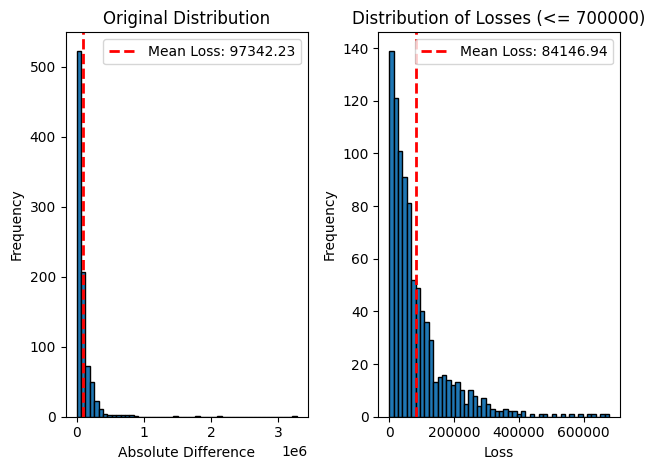

In [119]:
scale = min_scale
loss = []

for index, sample in tqdm(evaluation.iterrows()):
    nearest_neighbor, _ = find_k_neighbors(sample, communities_dict, k=3)

    predicted_price = adapt_price_from_dissimilarities(sample, nearest_neighbor, weight_dict, scale=scale)
    actual_price = sample["price"]
    loss.append(abs(actual_price - predicted_price))

mean_loss = np.mean(loss)
plt.subplot(1, 2, 1)
plt.hist(loss, bins=50, edgecolor='black')
plt.axvline(mean_loss, color='red', linestyle='dashed', linewidth=2, label=f'Mean Loss: {mean_loss:.2f}')
plt.title('Original Distribution')
plt.xlabel('Absolute Difference')
plt.ylabel('Frequency')
plt.legend()

filtered_losses = [l for l in loss if l <= 700000]
mean_loss = np.mean(filtered_losses)
plt.subplot(1, 2, 2)
plt.hist(filtered_losses, bins=50, edgecolor='black')
plt.axvline(mean_loss, color='red', linestyle='dashed', linewidth=2, label=f'Mean Loss: {mean_loss:.2f}')
plt.title('Distribution of Losses (<= 700000)')
plt.xlabel('Loss')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()